In [1]:
%matplotlib inline
import io
import sys
import os
import numpy as np
import numba as nb
import json
import subprocess
import base64
from scipy.spatial.transform import Rotation as RotationS

pyrobot_path = os.path.expanduser("~/pyrobot/src")
sys.path.append(pyrobot_path)
from pyrobot.core import Robot
from pyrobot import util
import numpy as np
import tf
bot = Robot("tm700")
listenser = tf.TransformListener()
import rospy

source_frame = 'camera_color_optical_frame'
target_frame = 'base_link'
virtual_cam_frame = 'virtual_cam'

def grasp2pts(x):
    x_mean = x.mean(axis=0)
    x_up = (x[0]+x[1])/2.0
    return (x_mean, x_up)

class GraspHandler(object):
    def __init__(self, grasp_provider="./grasp_provider.py"):
        self.sub_process = subprocess.Popen((grasp_provider,), stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    def get(self, img, depth):
        with io.BytesIO() as fp:
            np.save(fp, img, allow_pickle=True, fix_imports=True)
            img_b64 = base64.b64encode(fp.getvalue()).decode("utf-8")
        with io.BytesIO() as fp:
            np.save(fp, depth, allow_pickle=True, fix_imports=True)
            depth_b64 = base64.b64encode(fp.getvalue()).decode("utf-8")

        command = img_b64 + " " + depth_b64 + "\n"
        self.sub_process.stdin.write(command.encode())
        response = self.sub_process.stdout.readline().decode("utf-8")
        return json.loads(response)
    def best_grasp(self, img, depth):
        return self.get_topK(img, depth, K=1)[0]
    def get_topK(self, img, depth, K=5):
        all_grasp = []
        all_score = []
        results = self.get(img, depth)
        grasps = results['grasp']
        scores = results['confidence']
        for i, grasp_c in enumerate(grasps):
            for j, grasp_b in enumerate(grasp_c):
                x, y = np.asarray(grasp_b, dtype=np.float32).mean(axis=0).astype(np.int32).tolist()
                x = min(img.shape[1]-1, max(0, x))
                y = min(img.shape[0]-1, max(0, y))
                if depth[y,x]<=0.1:
                    continue
                all_grasp.append( grasp_b )
                all_score.append( -scores[i][j] )
        all_grasp = np.asarray(all_grasp)
        return all_grasp[np.argsort(all_score)[:K]]
    def __del__(self):
        self.sub_process.kill()

In [2]:
def get_xyz_transform(listenser, target_frame, source_frame):
    '''
    listenser: tf listenser
    target_frame: base
    source_frame: camera
    ---
    tuple: (trans, quat)
    -- trans: tranlation matrix (3,), tx,ty,tz
    -- quat: quaternion (4,) x,y,z,w
    '''
    try:
        now = rospy.Time.now()
        listenser.waitForTransform(target_frame, source_frame, now, rospy.Duration(10))
        trans, quat = listenser.lookupTransform(target_frame, source_frame, now)
        #print(trans) #tx, ty, tz
        #print(quat) # i, j, k ,w
    except (tf.LookupException,
                tf.ConnectivityException,
                tf.ExtrapolationException):
            raise RuntimeError('Cannot fetch the transform from {0:s} to {1:s}'.format(source_frame, target_frame))
    return trans, quat 

def transform_pts(pts, trans, quat):
    '''
    pts: (N,3) -- x,y,z
    trans: (3,) -- translation matrix
    quat: (4,) -- quanternion (rotation)
    ---
    rpts: (N,3) -- transformed x,y,z
    '''
    R = RotationS.from_quat(quat)
    return R.apply(pts) + np.asarray(trans,dtype=pts.dtype)[np.newaxis]

def transform_pts_wrt_base_link(pts, listenser, target_frame, source_frame, return_transform=False):
    trans, quat = get_xyz_transform(listenser, target_frame, source_frame)
    return transform_pts(pts, trans, quat) if not return_transform else (transform_pts(pts, trans, quat), trans, quat)

def get_xyz_rgb(bot):
    '''
    bot: Robot tm700
    ---
    rpts: ndarray (H, W, 3) -- x, y, z
    '''
    mat, _, _ = bot.camera.get_intrinsics()
    rgb, depth = bot.camera.get_rgb_depth()
    none_region = (depth==0)
    mat_inv = np.linalg.inv(mat) # (3,3)
    depth = depth / 1e3
    y = np.arange(0, depth.shape[0])
    x = np.arange(0, depth.shape[1])
    xv, yv = np.meshgrid(x, y)
    xy = np.append(xv[np.newaxis], yv[np.newaxis], axis=0) # (2, H, W) -- xy
    xy_homogeneous = np.pad(xy, ((0,1),(0,0),(0,0)), mode='constant', constant_values=1) # (3, H, W) -- x, y, 1
    xy_homogeneous_shape = xy_homogeneous.shape
    xy_h_flat = xy_homogeneous.reshape(3, -1) # (3, H*W) -- x, y, 1
    xy_h_flat_t = np.dot(mat_inv, xy_h_flat) # (3,3) x (3, H*W) -> (3, H*W)
    xy_homogeneous_t = xy_h_flat_t.reshape(xy_homogeneous_shape) # (3, H, W)
    xyz = np.transpose(xy_homogeneous_t*depth[np.newaxis], (1,2,0)) # (H, W, 3) -- x, y, z
    xyz[none_region,-1] = np.min(xyz[~none_region,-1])
    return xyz, rgb

def get_heightmap(bot, listenser, target_frame='base_link', source_frame='camera_color_optical_frame', return_transform=False):
    xyz, rgb = get_xyz_rgb(bot) # (H, W, 3)
    xyz_shape = xyz.shape
    xyz_f = xyz.reshape(-1, 3) # (H*W, 3)
    xyz_transformed, trans, quant = transform_pts_wrt_base_link(xyz_f, listenser, target_frame=target_frame, source_frame=source_frame, return_transform=True)
    xyz_transformed = xyz_transformed.reshape(xyz_shape)
    return (xyz_transformed, rgb) if not return_transform else (xyz_transformed, rgb, trans, quant)

def process_heighmap_range(heightmap, lower=-0.03, upper=0.13):
    depth_ = heightmap.copy()
    invalid_region = ((depth_<lower) | (depth_>upper))
    depth_ = (depth_.clip(lower, upper) - lower) / (upper-lower)
    depth_[invalid_region] = 0
    return depth_, invalid_region

In [3]:
import tf2_ros
import geometry_msgs.msg
from scipy.interpolate import NearestNDInterpolator
def setup_virtual_cam(cam_center=[-0.15, 0.34, 0.75], reference='base_link', virtual_cam_name='virtual_cam'):
    trans, quat = util.get_tf_transform(listenser, reference, reference)
    trans=np.array(cam_center)
    quat = np.array(quat)
    rot = tf.transformations.euler_matrix(0, np.pi, 0)
    rot = tf.transformations.quaternion_from_matrix(rot)
    quat = tf.transformations.quaternion_multiply(rot, quat)
    broadcaster = tf2_ros.StaticTransformBroadcaster()

    static_tf = geometry_msgs.msg.TransformStamped()
    static_tf.header.stamp = rospy.Time.now()
    static_tf.header.frame_id = reference # src frame (base_link)
    static_tf.child_frame_id = virtual_cam_name # dst frame

    static_tf.transform.translation.x = trans[0]
    static_tf.transform.translation.y = trans[1]
    static_tf.transform.translation.z = trans[2]

    static_tf.transform.rotation.x = quat[0]
    static_tf.transform.rotation.y = quat[1]
    static_tf.transform.rotation.z = quat[2]
    static_tf.transform.rotation.w = quat[3]
    broadcaster.sendTransform(static_tf)
    #rospy.spin()

def get_camera_uv(xyz, bot, listenser, target, source):
    h, w = xyz.shape[:2]
    xyz_f = xyz.copy()
    xyz_f = xyz_f.reshape(-1,3)
    mat, _, _ = bot.camera.get_intrinsics()
    trans, quat = get_xyz_transform(listenser, target, source)
    xyz_f = transform_pts(xyz_f, trans, quat)
    #xyz_h = np.pad(xyz_f, ((0,0), (0,1)), mode='constant', constant_values=1)
    uvw = np.dot(mat,xyz_f.T).T
    uv = (uvw / uvw[...,-1:])[:,:2]
    uv = uv.reshape(h, w, 2)
    return uv

@nb.jit(nopython=True)
def apply_uv(uv, rgb, depth, xyz):
    new_rgb = np.zeros_like(rgb)
    new_depth = np.zeros_like(depth)
    new_xyz = np.zeros_like(xyz)
    missing = np.ones(depth.shape, dtype=np.uint8)
    h, w = uv.shape[:2]
    for r in range(h):
        for c in range(w):
            j = int(round(uv[r,c,0]))
            i = int(round(uv[r,c,1]))
            if i>=0 and j>=0 and i<rgb.shape[0] and j<rgb.shape[1]:
                if depth[r,c]>new_depth[i,j]:
                    new_rgb[i,j] = rgb[r,c]
                    new_depth[i,j] = depth[r,c]
                    new_xyz[i,j] = xyz[r,c]
                missing[i,j] = 0
    return new_rgb, new_depth, new_xyz, missing

#@nb.jit(nopython=True)
def apply_uv_fast(uv, rgb, depth, xyz, npts_for_h=16):
    h, w = rgb.shape[:2]
    dst = []
    src = []
    while len(dst)<npts_for_h:
        i = np.random.randint(h)
        j = np.random.randint(w)
        pt = uv[i,j]
        if (pt>=0).all() and pt[0]<w and pt[1]<h and depth[i,j]>0:
            if len(src)>0 and np.min(np.linalg.norm(np.asarray(src) - pt[np.newaxis])) < 12:
                continue
            dst.append(pt)  # (x,y)
            src.append([j,i]) # (x,y)
    src = np.asarray(src, dtype=np.float32)
    dst = np.asarray(dst, dtype=np.float32)
    M, match_mask = cv2.findHomography(src,dst)
    new_rgb = cv2.warpPerspective(rgb, M, (w, h))
    new_depth = cv2.warpPerspective(depth, M, (w, h))
    new_xyz = cv2.warpPerspective(xyz, M, (w, h))
    return new_rgb, new_depth, new_xyz

def inward_interp(data, mask):
    #orignal = data.copy()
    missing = mask
    mask = ~missing # valid
    xx, yy = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T

    # the valid values in the first, second, third color channel,  as 1D arrays (in the same order as their coordinates in xym)
    
    # N separate interpolators for the separate color channels
    datas = []
    for i in range(data.shape[-1]):
        datas.append( np.ravel( data[:,:,i][mask] ) )

    # three separate interpolators for the separate color channels
    interp = []
    for i in range(data.shape[-1]):
        interp.append( NearestNDInterpolator( xym, datas[i] ) )

    # interpolate the whole image, one color channel at a time
    results = []
    for i in range(data.shape[-1]):
        results.append(interp[i](np.ravel(xx), np.ravel(yy)).reshape( xx.shape ))

    # combine them into an output image
    result = np.dstack( results )
    #print(result.shape, missing.shape)
    #orignal[missing] = result[missing]
    return result

def fill_holes(rgb, depth, xyz, mask=None):
    if mask is None:
        mask = (depth<=0)
    mask = mask.astype(np.bool)
    depth = depth.astype(np.float32)
    xyz   = xyz.astype(np.float32)
    depth -= depth.min()
    depth = np.round(depth / depth.max() * 255).clip(0,255).astype(np.uint8)
    rgb = rgb.astype(np.uint8)
    inward_interp(rgb, mask)
    return inward_interp(rgb, mask), inward_interp(depth[...,np.newaxis], mask)[...,0], inward_interp(xyz, mask)

In [4]:
setup_virtual_cam(reference=target_frame, virtual_cam_name=virtual_cam_frame)

In [5]:
test = GraspHandler()

In [6]:
import cv2
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#init_notebook_mode(connected=True)

In [7]:
xyz, img = get_heightmap(bot, listenser, target_frame=target_frame, source_frame=source_frame)
depth = xyz[...,-1]
depth, invalid_region = process_heighmap_range(depth, lower=-0.03, upper=0.15)
depth[:400] = 0
depth[:,:400] = 0
#img[depth==0] = 140


In [8]:
uv = get_camera_uv(xyz, bot, listenser, virtual_cam_frame, target_frame)
#new_img, new_depth, new_xyz, missing = apply_uv(uv, img, depth, xyz)
#new_img, new_depth, new_xyz = fill_holes(new_img, new_depth, new_xyz, mask=missing.astype(np.bool))
new_img, new_depth, new_xyz = apply_uv_fast(uv, img, depth, xyz)

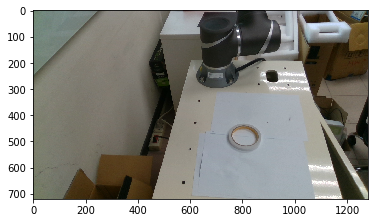

In [9]:
plt.imshow(img)
plt.show()

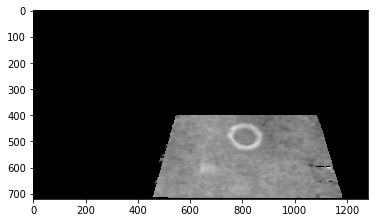

In [10]:
plt.imshow(depth, cmap='gray')
plt.show()

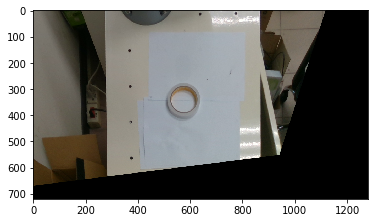

In [11]:
plt.imshow(new_img)
plt.show()

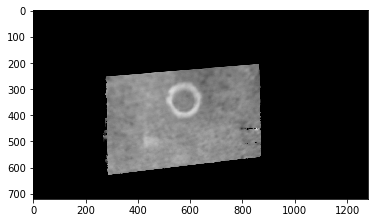

In [12]:
plt.imshow(new_depth, cmap='gray')
plt.show()

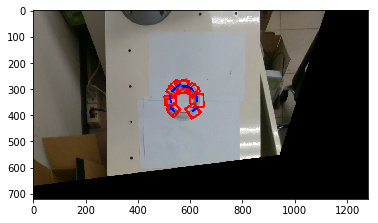

In [13]:
pts = test.get_topK(new_img,new_depth,K=20)
img_ = np.copy(new_img)
cv2.polylines(img_, pts.astype(np.int32), True, (255,0,0), 5)
vecs = [ grasp2pts(pt) for pt in pts ]
for vec in vecs:
    cv2.line(img_, tuple(vec[0].astype(np.int32)), tuple(vec[1].astype(np.int32)), (0,0,255), 5)
plt.imshow(img_)
plt.show()

In [14]:
def deg_diff(u_, v_):
    u = u_.astype(np.float32)
    v = v_.astype(np.float32)
    costha = np.sum(u*v) / (np.linalg.norm(u)*np.linalg.norm(v))
    rad = np.arccos(costha)
    return rad

def apply_grasp_pose(bot, xyz, x0_, x1_, target_frame, listener, gripper_height=0.15):
    x0 = x0_.astype(np.int32)
    x1 = x1_.astype(np.int32)
    pt1_ = xyz[x0[1],x0[0]] # grasp in base_link
    pt1, height = pt1_[:2], pt1_[2]
    pt2 = xyz[x1[1],x1[0]][:2] # grasp in base_link
    u = np.array([0,10],dtype=np.float32)
    v = pt2-pt1
    if v[1]<0:
        v = -v
    print(v)
    rad = deg_diff(u,v)
    if v[0]<0:
        rad = -rad
    print(np.degrees(rad))
    rot_grasp = tf.transformations.euler_matrix(0, 0, rad)
    rot_grasp = tf.transformations.quaternion_from_matrix(rot_grasp)
    # pose = bot.arm.get_ee_pose()
    trans, quat = util.get_tf_transform(listener, target_frame, target_frame)
    quat = np.array(quat)
    # rotate orientation by y
    rot = tf.transformations.euler_matrix(0, np.pi, 0)
    rot = tf.transformations.quaternion_from_matrix(rot)
    quat = tf.transformations.quaternion_multiply(rot_grasp, quat)
    quat = tf.transformations.quaternion_multiply(rot, quat)
    #quat = tf.transformations.quaternion_multiply(rot_grasp, quat)
    final_r = RotationS.from_quat(np.asarray(quat)).as_euler('xyz', degrees=True).clip(-179.9,179.9)
    quat = RotationS.from_euler('xyz', final_r, degrees=True).as_quat()
    
    height = gripper_height + max(0.01,height)
    trans = np.array([pt1[0], pt1[1], height])
    print(trans, final_r.astype(np.int32))
    bot.arm.set_ee_pose(trans, quat)

[-0.01051028  0.01130039]
-42.92532
(array([-0.07905452,  0.37509502,  0.16      ]), array([-179,    0, -137], dtype=int32))
[INFO] [1565597276.224798]: Moveit Motion Planning...
[INFO] [1565597276.287126]: Executing...


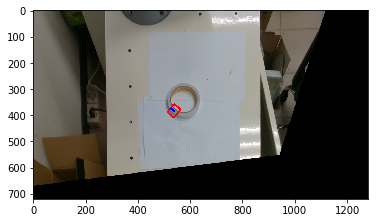

[-0.0080597   0.01060574]
-37.232594
(array([-0.07503127,  0.36838944,  0.16      ]), array([-179,    0, -142], dtype=int32))
[INFO] [1565597287.573712]: Moveit Motion Planning...
[INFO] [1565597287.624675]: Executing...


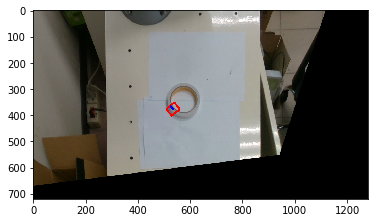

[-0.0080597   0.01060574]
-37.232594
(array([-0.07503127,  0.36838944,  0.16      ]), array([-179,    0, -142], dtype=int32))
[INFO] [1565597287.973494]: Moveit Motion Planning...
[INFO] [1565597288.027288]: Executing...


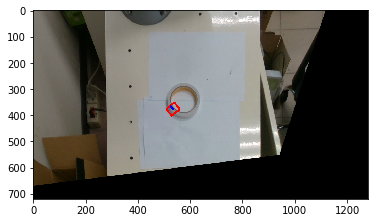

[-0.00897684  0.00940171]
-43.675694
(array([-0.13866688,  0.31246791,  0.16      ]), array([-179,    0, -136], dtype=int32))
[INFO] [1565597292.172736]: Moveit Motion Planning...
[INFO] [1565597292.207987]: Executing...


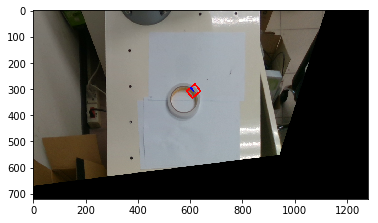

[-0.01125118  0.00836886]
-53.35736
(array([-0.13376225,  0.30920247,  0.16      ]), array([-179,    0, -126], dtype=int32))
[INFO] [1565597293.755583]: Moveit Motion Planning...
[INFO] [1565597293.792031]: Executing...


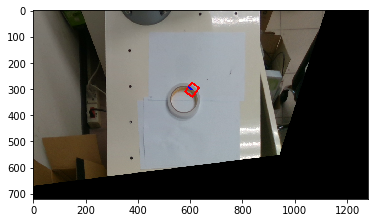

[-0.01125118  0.00836886]
-53.35736
(array([-0.13376225,  0.30920247,  0.16      ]), array([-179,    0, -126], dtype=int32))
[INFO] [1565597295.311740]: Moveit Motion Planning...
[INFO] [1565597295.368939]: Executing...


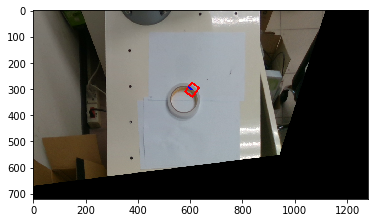

[0.00718747 0.01037424]
34.714928
(array([-0.07264627,  0.31808447,  0.16      ]), array([179,   0, 145], dtype=int32))
[INFO] [1565597295.997418]: Moveit Motion Planning...
[INFO] [1565597296.046007]: Executing...


KeyboardInterrupt: 

In [15]:
for i in range(len(pts)):
    best_grasp = grasp2pts(pts[i])
    apply_grasp_pose(bot, new_xyz, best_grasp[0], best_grasp[1], target_frame, listenser)
    img_ = np.copy(new_img)
    cv2.polylines(img_, [pts[i].astype(np.int32)], True, (255,0,0), 5)
    pt = grasp2pts(pts[i])
    cv2.line(img_, tuple(pt[0].astype(np.int32)), tuple(pt[1].astype(np.int32)), (0,0,255), 5)
    plt.imshow(img_)
    plt.show()